In [21]:
import pandas as pd 
import re
import nltk 
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np 
#train models 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import seaborn as sn
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [22]:
# Setting up stats dataframe
import time
stats = pd.DataFrame(columns=['Algorithm','Label','Accurary','Precision','Recall','F1','Time'])

# Get the data

In [23]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
train.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


# Cleaning data

## Preprocessing words

In [10]:
def normalize(df): 
    corpus = []
    ps = PorterStemmer()
    df_size = len(df) 
    for i in range(0,df_size):
        # get review and remove non alpha chars
        article = re.sub('[^a-zA-Z]', ' ', df['ABSTRACT'][i])
        # to lower-case and tokenize
        article = article.lower().split()
        # stemming and stop word removal
        article = ' '.join([ps.stem(w) for w in article if not w in set(stopwords.words('english'))])
        corpus.append(article)
    return corpus

# To avoid making this cleaning every time, we save teh output as a csv
def save_csv(corpus_train, file_name): 
    df = pd.DataFrame({'text': corpus_train})
    df.to_csv(file_name) 
    
train['ABSTRACT'] = train['TITLE'] +train['ABSTRACT']
corpus_train = normalize(train)
save_csv(corpus_train, 'preprocessed_train.csv')

test['ABSTRACT'] = test['TITLE'] + test['ABSTRACT']
corpus_test = normalize(test)
save_csv(corpus_test, 'preprocessed_test.csv')


KeyboardInterrupt: 

# Split input and output

In [24]:
def get_input(preprocessed, x_col_name): 
    vectorizer = CountVectorizer(max_features = 1500)

    X_array = preprocessed.loc[:,x_col_name]
    X = vectorizer.fit_transform(X_array).toarray()
    return X

def get_outputs(df, y_cols_name):
    y = []
    for col_name in y_cols_name: 
        col_values = df.loc[:,col_name].values
        y.append(col_values)
    return y


preprocessed = pd.read_csv('preprocessed_train.csv')
preprocessed_submission = pd.read_csv('preprocessed_test.csv')
y_columns = train.columns[3:]
X = get_input(preprocessed, 'text')
y = get_outputs(train, y_columns)
X_submission = get_input(preprocessed_submission, 'text')

# Split train and test sets

In [25]:
y_train_test = []
for i in range(len(y_columns)): 
    X_train, X_test, y_train, y_test = train_test_split(X, y[i], test_size = 0.20, random_state = 0)
    y_train_test.append([y_train, y_test])

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(y_columns)

(16777, 1500) (16777,)
(4195, 1500) (4195,)
Index(['Computer Science', 'Physics', 'Mathematics', 'Statistics',
       'Quantitative Biology', 'Quantitative Finance'],
      dtype='object')


# Oversampling 
Run this cell only with it's desired to run the oversamplying. 

In [26]:
sm = SMOTE(random_state=12)
quant_biology_train_y = y_train_test[4][0];
quant_finance_train_y = y_train_test[5][0];  

x_biology, y_train_test[4][0] = sm.fit_resample(X_train, quant_biology_train_y)
x_finance, y_train_test[5][0] = sm.fit_resample(X_train, quant_finance_train_y)


# Train the model and generate results

In [27]:
def print_statistics(y_test, y_pred, column_name): 
   # print(confusion_matrix(y_test, y_pred))
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred))
    print('Recall: ', recall_score(y_test, y_pred))
    print('F1: ', f1_score(y_test, y_pred))
    print()
    
def get_statistics(y_test, y_pred, column_name): 
    return [accuracy_score(y_test, y_pred),precision_score(y_test, y_pred),recall_score(y_test, y_pred),f1_score(y_test, y_pred)]

In [28]:
def get_x_train(index, with_oversampling):
    if index == 4 and with_oversampling: 
        return x_biology
    elif index == 5 and with_oversampling: 
        return x_finance
    return X_train 

# Statistics and train

In [29]:
def prepare_statistic(df):
    x = ['Accuracy', 'Precision', 'Recall', 'F1'] 
    title = df.iloc[1]
    y = df.iloc[2:].tolist()
    return x, y, title


def plot_statistics(stats): 
    fig, axs = plt.subplots(2, 3, sharex=True, sharey=True) 
    fig.set_figwidth(20)
    fig.set_figheight(7)
    for i in range(2): 
        for j in range(3): 
            index = i*3 + j 
            df = stats[index]
            x, y, title = prepare_statistic(df) 
            axs[i,j].bar(x,y)
            axs[i,j].set_title(title)
            axs[i,j].grid(True)
    plt.show()
            
def plot_time(arr, title):
    x = ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantative Biology', 'Quantitative Finance']
    y = arr 
    fig = plt.figure()
    fig.set_figwidth(15)
    fig.set_figheight(5)
    plt.bar(x,y)
    plt.title(title)
    plt.show()
    
times = {}

LABEL ::  Computer Science
Accuracy:  0.769249106078665
Precision:  0.6594083812654067
Recall:  0.9202981651376146
F1:  0.7683101962661559

LABEL ::  Physics
Accuracy:  0.8982121573301549
Precision:  0.8029944838455477
Recall:  0.8520066889632107
F1:  0.8267748478701827

LABEL ::  Mathematics
Accuracy:  0.8011918951132301
Precision:  0.5714285714285714
Recall:  0.8967441860465116
F1:  0.6980448950036205

LABEL ::  Statistics
Accuracy:  0.6598331346841478
Precision:  0.4120999561595791
Recall:  0.9161793372319688
F1:  0.5684910795282734

LABEL ::  Quantitative Biology
Accuracy:  0.9501787842669845
Precision:  0.04854368932038835
Recall:  0.04310344827586207
F1:  0.04566210045662101

LABEL ::  Quantitative Finance
Accuracy:  0.9828367103694875
Precision:  0.041666666666666664
Recall:  0.02
F1:  0.02702702702702703



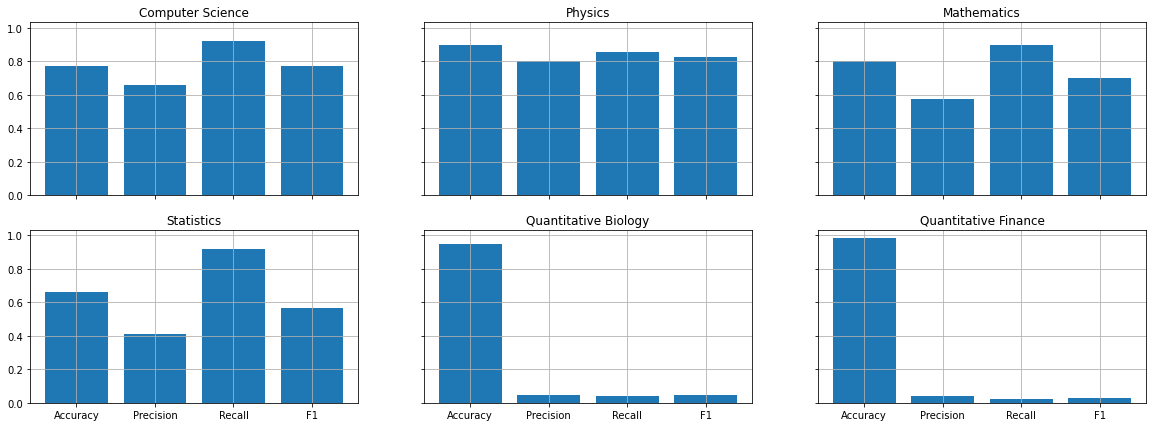

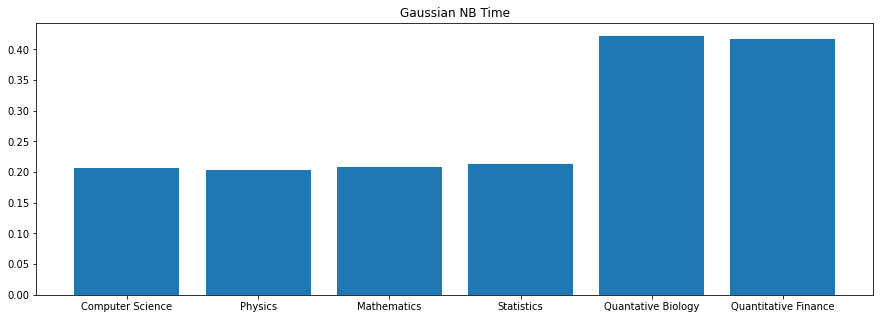

In [30]:
classifier = GaussianNB()
gaussian_df = pd.DataFrame()
gaussian_submission_df = pd.DataFrame() 
time_nb = []
stats_nb = []
for i in range(len(y_columns)): 
    col_name = y_columns[i]
    print("LABEL :: ", col_name)
    y_train = y_train_test[i][0]
    y_test = y_train_test[i][1]
    x_train = get_x_train(i,True) 
    
    begin = time.time()
    classifier.fit(x_train, y_train)
    end = time.time()
    
    gaussian_df[col_name]= classifier.predict(X_test)
    gaussian_submission_df[col_name] = classifier.predict(X_submission)
    
    print_statistics(y_test, gaussian_df[col_name].values, col_name)
    stat_array = get_statistics(y_test, gaussian_df[col_name].values, col_name)
    stats_nb.append(pd.Series(['Naive Bayes',col_name,stat_array[0],stat_array[1],stat_array[2],stat_array[3]]))
    time_nb.append(end-begin) 


plot_statistics(stats_nb)
times['nb'] = time_nb
plot_time(time_nb, "Gaussian NB Time")


LABEL ::  Computer Science


/home/allanbs/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Accuracy:  0.832657926102503
Precision:  0.8131009615384616
Recall:  0.775802752293578
F1:  0.7940140845070423


LABEL ::  Physics


/home/allanbs/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Accuracy:  0.9091775923718712
Precision:  0.8540399652476107
Recall:  0.8219063545150501
F1:  0.8376651043885811


LABEL ::  Mathematics


/home/allanbs/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Accuracy:  0.8805721096543504
Precision:  0.7576301615798923
Recall:  0.7851162790697674
F1:  0.771128369118319


LABEL ::  Statistics


/home/allanbs/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Accuracy:  0.8598331346841478
Precision:  0.7305263157894737
Recall:  0.6764132553606238
F1:  0.702429149797571


LABEL ::  Quantitative Biology


/home/allanbs/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Accuracy:  0.9432657926102503
Precision:  0.195
Recall:  0.33620689655172414
F1:  0.2468354430379747


LABEL ::  Quantitative Finance


/home/allanbs/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Accuracy:  0.9821215733015495
Precision:  0.288135593220339
Recall:  0.34
F1:  0.3119266055045872




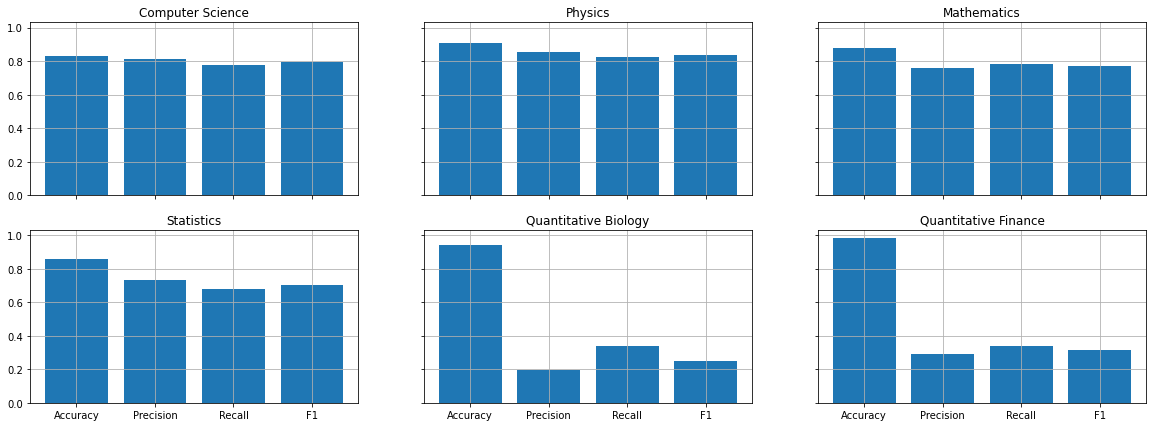

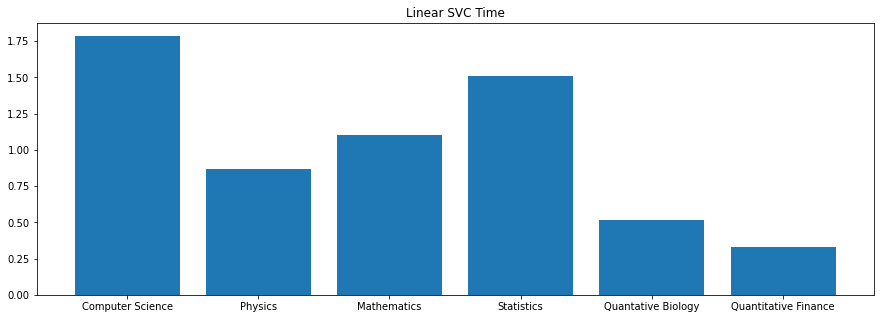

In [31]:
# SVM

from sklearn.svm import LinearSVC


classifier = LinearSVC()
gaussian_df = pd.DataFrame()
gaussian_submission_df = pd.DataFrame() 
time_svm = []
stats_svm = []
for i in range(len(y_columns)): 
    col_name = y_columns[i]
    print("LABEL :: ", col_name)
    y_train = y_train_test[i][0]
    y_test = y_train_test[i][1]
    x_train = get_x_train(i, True)
    
    begin = time.time()
    classifier.fit(x_train, y_train)
    end = time.time()
    gaussian_df[col_name]= classifier.predict(X_test)
    gaussian_submission_df[col_name] = classifier.predict(X_submission)
    print_statistics(y_test, gaussian_df[col_name].values, col_name)
    stat_array = get_statistics(y_test, gaussian_df[col_name].values, col_name)
    print()
    stats_svm.append(pd.Series(['Support Vector Machines',col_name,stat_array[0],stat_array[1],stat_array[2],stat_array[3]]))
    time_svm.append(end-begin)
    
plot_statistics(stats_svm)
times['svm'] = time_svm
plot_time(time_svm, "Linear SVC Time")

LABEL ::  Computer Science


/home/allanbs/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy:  0.8348033373063171
Precision:  0.8141063956963539
Recall:  0.7809633027522935
F1:  0.797190517998244


LABEL ::  Physics


/home/allanbs/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy:  0.9115613825983313
Precision:  0.8565254969749352
Recall:  0.8285953177257525
F1:  0.8423289417764556


LABEL ::  Mathematics


/home/allanbs/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy:  0.8815256257449344
Precision:  0.7594254937163375
Recall:  0.7869767441860465
F1:  0.7729556875285517


LABEL ::  Statistics


/home/allanbs/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy:  0.8588796185935638
Precision:  0.7269874476987448
Recall:  0.6773879142300195
F1:  0.7013118062563068


LABEL ::  Quantitative Biology


/home/allanbs/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy:  0.9466030989272944
Precision:  0.2
Recall:  0.3103448275862069
F1:  0.24324324324324326


LABEL ::  Quantitative Finance


/home/allanbs/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy:  0.9828367103694875
Precision:  0.2962962962962963
Recall:  0.32
F1:  0.30769230769230765




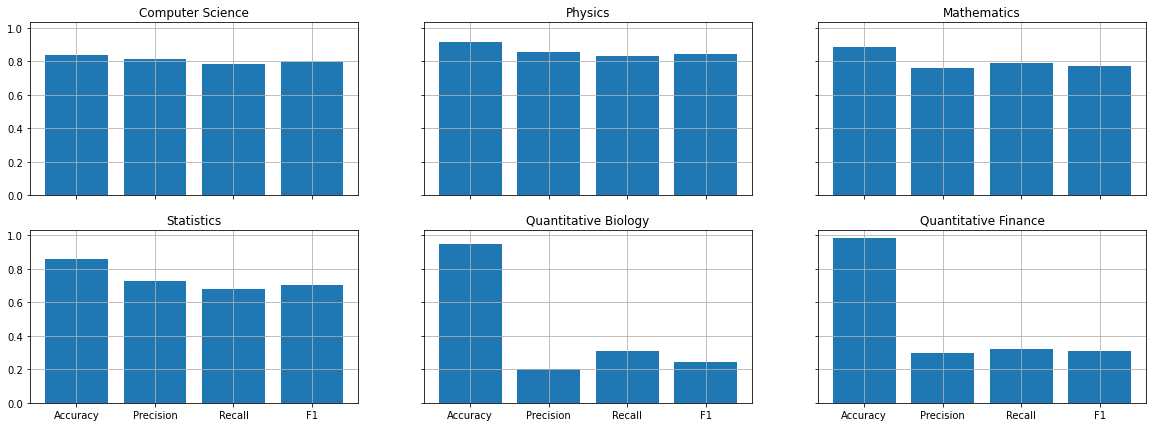

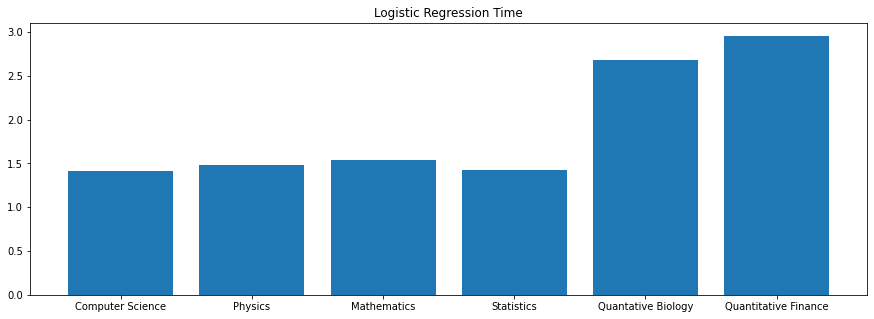

In [32]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
gaussian_df = pd.DataFrame()
gaussian_submission_df = pd.DataFrame() 

time_lr = []
stats_lr = []
for i in range(len(y_columns)): 
    col_name = y_columns[i]
    print("LABEL :: ", col_name)
    y_train = y_train_test[i][0]
    y_test = y_train_test[i][1]
    x_train = get_x_train(i, True)
    
    begin = time.time()
    classifier.fit(x_train, y_train)
    end = time.time()
    gaussian_df[col_name]= classifier.predict(X_test)
    gaussian_submission_df[col_name] = classifier.predict(X_submission)
    print_statistics(y_test, gaussian_df[col_name].values, col_name)
    stat_array = get_statistics(y_test, gaussian_df[col_name].values, col_name)
    print()
    stats_lr.append(pd.Series(['Logistic Regression',col_name,stat_array[0],stat_array[1],stat_array[2],stat_array[3]]))
    time_lr.append(end-begin)
    
plot_statistics(stats_lr)
times['lr'] = time_lr
plot_time(time_lr, "Logistic Regression Time")

LABEL ::  Computer Science
Accuracy:  0.8019070321811681
Precision:  0.7529085872576178
Recall:  0.779243119266055
F1:  0.7658495350803043


LABEL ::  Physics
Accuracy:  0.9072705601907032
Precision:  0.8524017467248908
Recall:  0.8160535117056856
F1:  0.8338316958564717


LABEL ::  Mathematics
Accuracy:  0.8791418355184744
Precision:  0.7736030828516378
Recall:  0.7469767441860465
F1:  0.7600567912920019


LABEL ::  Statistics
Accuracy:  0.8269368295589988
Precision:  0.6609442060085837
Recall:  0.6003898635477583
F1:  0.6292134831460674


LABEL ::  Quantitative Biology
Accuracy:  0.9480333730631705
Precision:  0.18902439024390244
Recall:  0.2672413793103448
F1:  0.22142857142857145


LABEL ::  Quantitative Finance
Accuracy:  0.9849821215733016
Precision:  0.37735849056603776
Recall:  0.4
F1:  0.38834951456310685




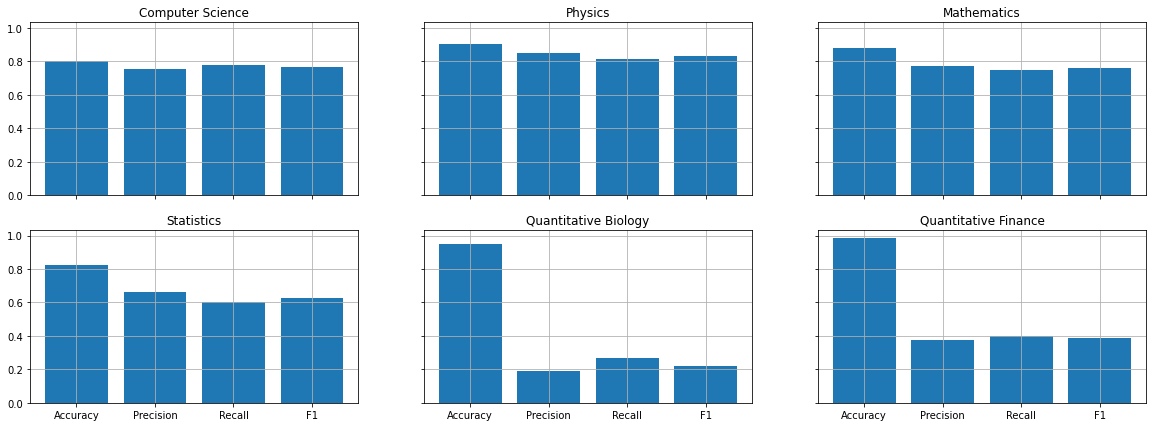

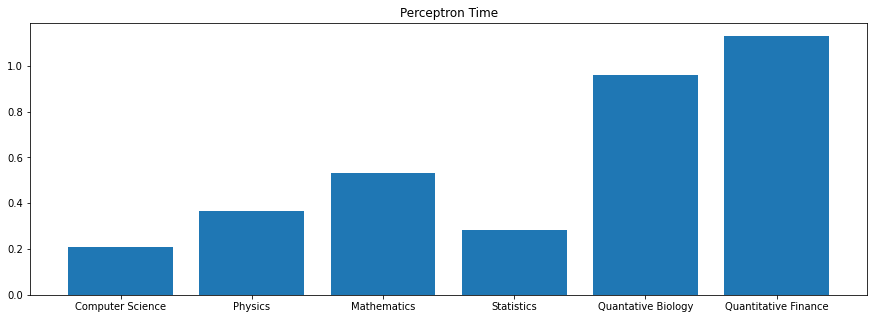

In [33]:
# Perceptron

from sklearn.linear_model import Perceptron

classifier = Perceptron()
gaussian_df = pd.DataFrame()
gaussian_submission_df = pd.DataFrame() 

stats_p = []
time_p = []
for i in range(len(y_columns)): 
    col_name = y_columns[i]
    print("LABEL :: ", col_name)
    y_train = y_train_test[i][0]
    y_test = y_train_test[i][1]
    x_train = get_x_train(i, True)
    
    begin = time.time()
    classifier.fit(x_train, y_train)
    end = time.time()
    gaussian_df[col_name]= classifier.predict(X_test)
    gaussian_submission_df[col_name] = classifier.predict(X_submission)
    print_statistics(y_test, gaussian_df[col_name].values, col_name)
    stat_array = get_statistics(y_test, gaussian_df[col_name].values, col_name)
    print()
    stats_p.append(pd.Series(['Perceptron',col_name,stat_array[0],stat_array[1],stat_array[2],stat_array[3]]))
    time_p.append(end-begin)


plot_statistics(stats_p)
times['p'] = time_p
plot_time(time_p, "Perceptron Time")

LABEL ::  Computer Science
Accuracy:  0.7623361144219308
Precision:  0.7162709901563404
Recall:  0.7092889908256881
F1:  0.7127628925381734


LABEL ::  Physics
Accuracy:  0.8584028605482718
Precision:  0.7512520868113522
Recall:  0.7525083612040134
F1:  0.7518796992481204


LABEL ::  Mathematics
Accuracy:  0.8288438617401669
Precision:  0.6569920844327177
Recall:  0.6948837209302325
F1:  0.6754068716094033


LABEL ::  Statistics
Accuracy:  0.8071513706793803
Precision:  0.6044273339749759
Recall:  0.6120857699805068
F1:  0.608232445520581


LABEL ::  Quantitative Biology
Accuracy:  0.9334922526817641
Precision:  0.15319148936170213
Recall:  0.3103448275862069
F1:  0.20512820512820512


LABEL ::  Quantitative Finance
Accuracy:  0.9735399284862932
Precision:  0.20388349514563106
Recall:  0.42
F1:  0.27450980392156865




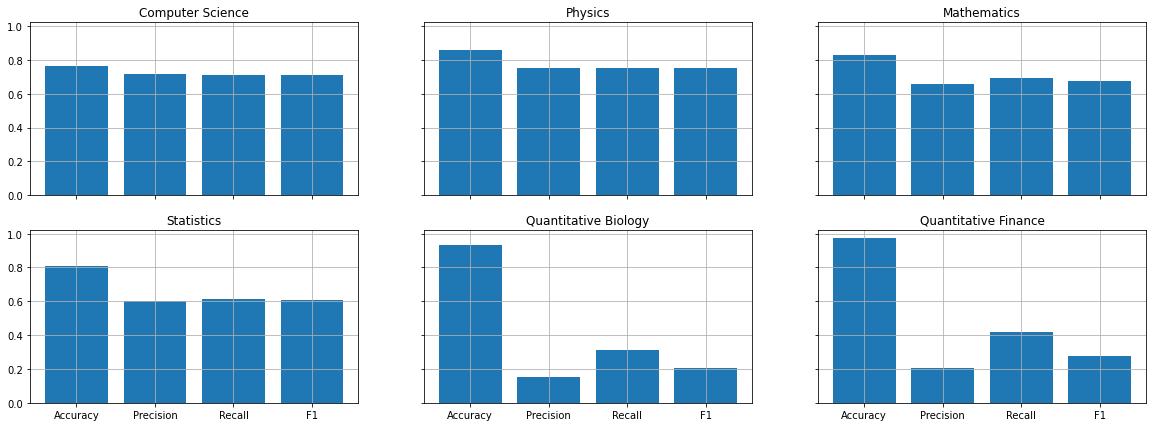

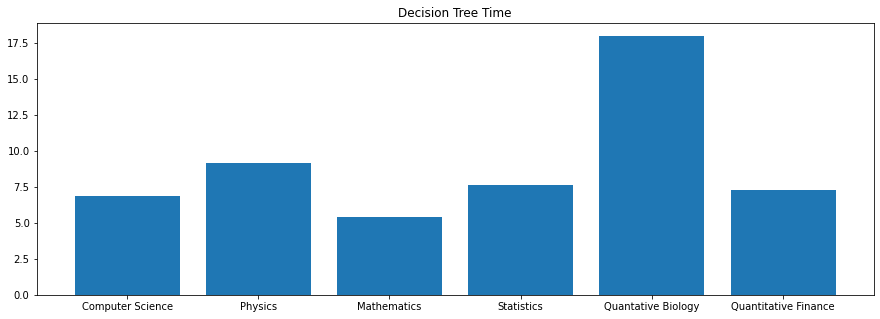

In [34]:
# Decision Tree

from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier()
gaussian_df = pd.DataFrame()
gaussian_submission_df = pd.DataFrame()
stats_dt = []
time_dt = []
for i in range(len(y_columns)): 
    col_name = y_columns[i]
    print("LABEL :: ", col_name)
    y_train = y_train_test[i][0]
    y_test = y_train_test[i][1]
    x_train = get_x_train(i, True)
    
    begin = time.time()
    classifier.fit(x_train, y_train)
    end = time.time()
    gaussian_df[col_name]= classifier.predict(X_test)
    gaussian_submission_df[col_name] = classifier.predict(X_submission)
    print_statistics(y_test, gaussian_df[col_name].values, col_name)
    stat_array = get_statistics(y_test, gaussian_df[col_name].values, col_name)
    print()
    stats_dt.append(pd.Series(['Decision Tree',col_name,stat_array[0],stat_array[1],stat_array[2],stat_array[3]]))
    time_dt.append(end-begin)

plot_statistics(stats_dt)
times['dt'] = time_dt
plot_time(time_dt, "Decision Tree Time")

LABEL ::  Computer Science
Accuracy:  0.8483909415971395
Precision:  0.7906610703043022
Recall:  0.864105504587156
F1:  0.8257534246575343


LABEL ::  Physics
Accuracy:  0.9132300357568534
Precision:  0.905458089668616
Recall:  0.7767558528428093
F1:  0.8361836183618362


LABEL ::  Mathematics
Accuracy:  0.8953516090584028
Precision:  0.8897058823529411
Recall:  0.6753488372093023
F1:  0.7678476996298254


LABEL ::  Statistics
Accuracy:  0.8700834326579261
Precision:  0.7812865497076024
Recall:  0.6510721247563352
F1:  0.710260499734184


LABEL ::  Quantitative Biology
Accuracy:  0.9697258641239571
Precision:  0.13333333333333333
Recall:  0.017241379310344827
F1:  0.030534351145038167


LABEL ::  Quantitative Finance
Accuracy:  0.9866507747318236
Precision:  0.125
Recall:  0.02
F1:  0.03448275862068966




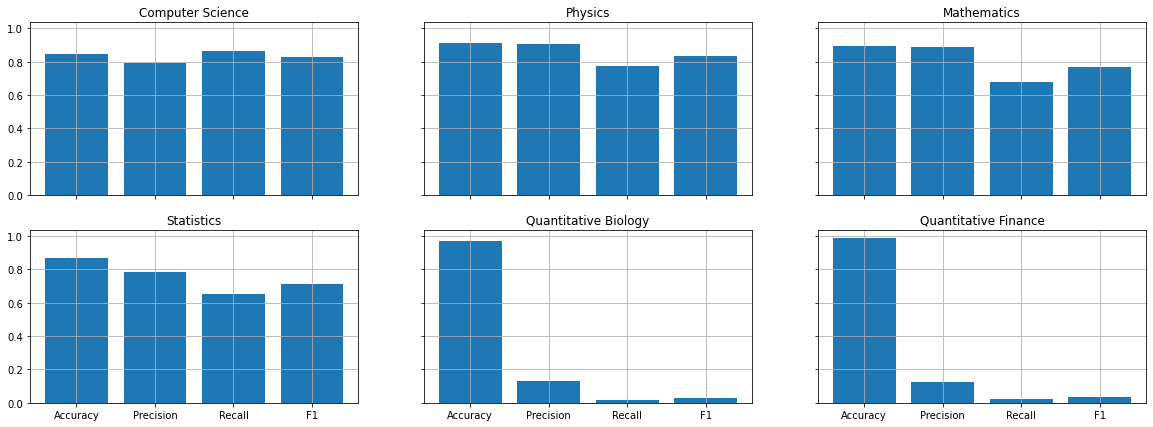

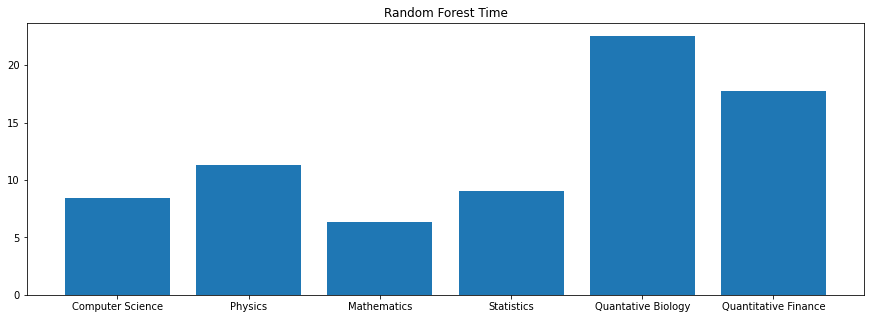

In [35]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()
gaussian_df = pd.DataFrame()
gaussian_submission_df = pd.DataFrame() 
stats_rf = []
time_rf = []
for i in range(len(y_columns)): 
    col_name = y_columns[i]
    print("LABEL :: ", col_name)
    y_train = y_train_test[i][0]
    y_test = y_train_test[i][1]
    x_train = get_x_train(i, True)
    
    begin = time.time()
    classifier.fit(x_train, y_train)
    end = time.time()
    gaussian_df[col_name]= classifier.predict(X_test)
    gaussian_submission_df[col_name] = classifier.predict(X_submission)
    print_statistics(y_test, gaussian_df[col_name].values, col_name)
    stat_array = get_statistics(y_test, gaussian_df[col_name].values, col_name)
    print()
    stats_rf.append(pd.Series(['Random Forest',col_name,stat_array[0],stat_array[1],stat_array[2],stat_array[3]]))
    time_rf.append(end-begin)
    
plot_statistics(stats_rf)
times['rf'] = time_rf
plot_time(time_rf, "Random Forest Time")

# Compare times 

## Compare times by label

<ipython-input-41-47d7486f6e79>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i,j].set_xticklabels(algorithms, rotation=45)


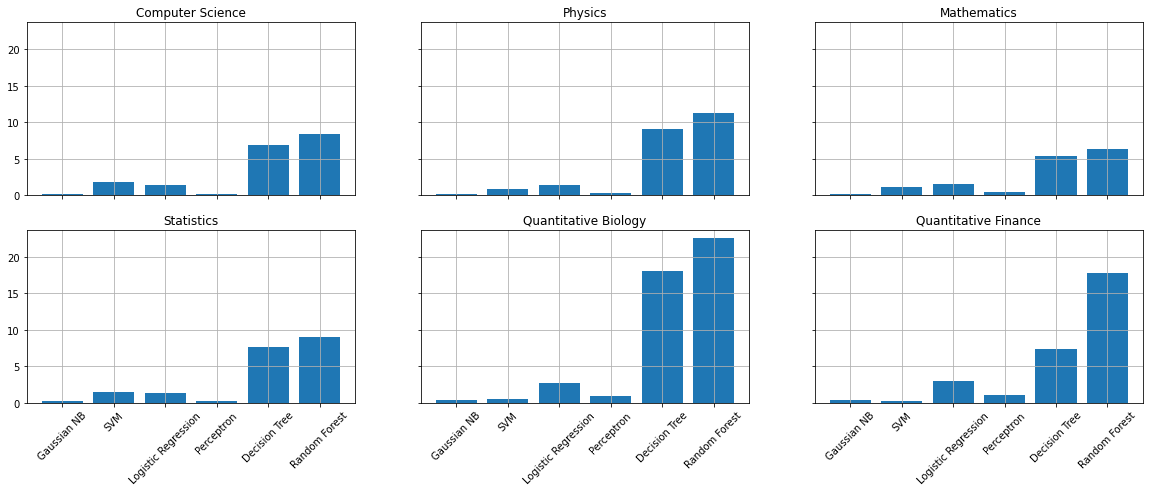

In [41]:
times = [time_nb, time_svm, time_lr, time_p, time_dt, time_rf]
columns = ["Computer Science", "Physics", "Mathematics", "Statistics", "Quantitative Biology", "Quantitative Finance"]
algorithms = ["Gaussian NB", "SVM", "Logistic Regression", "Perceptron", "Decision Tree", "Random Forest"]
aux_times = []
for i in range(len(time_nb)): 
    aux_times.append([])
    for j in range(len(times)): 
        aux_times[i].append(times[j][i]) 


fig, axs = plt.subplots(2, 3, sharex=True, sharey=True) 
fig.set_figwidth(20)
fig.set_figheight(7)

for i in range(2): 
    plt.xticks(rotation=45)
    for j in range(3): 
        index = i*3 + j 
        df = aux_times[index]
        x = algorithms
        y = aux_times[index]
        
        axs[i,j].bar(x,y)
        axs[i,j].set_title(columns[index])    
        axs[i,j].set_xticklabels(algorithms, rotation=45)
        axs[i,j].grid(True)
plt.show()

## Compare total time

[1.6706254482269287, 6.105411767959595, 11.506745100021362, 3.4763197898864746, 54.40650463104248, 75.45566368103027]


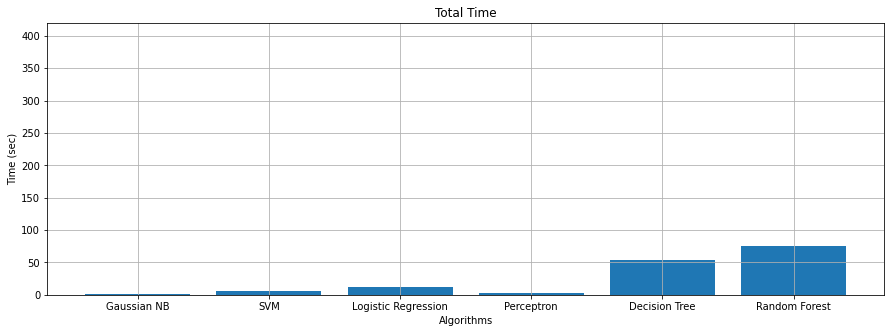

In [37]:
times = [time_nb, time_svm, time_lr, time_p, time_dt, time_rf]
algorithms = ["Gaussian NB", "SVM", "Logistic Regression", "Perceptron", "Decision Tree", "Random Forest"]
aux_times = []
for i in range(len(times)): 
    aux_times.append(sum(times[i])) 
    
print(aux_times)
fig = plt.figure()
axis = plt.gca()
axis.set_ylim([0,420])
axis.grid(True)
plt.ylabel("Time (sec)")
plt.xlabel("Algorithms")
fig.set_figwidth(15)
fig.set_figheight(5)
plt.bar(algorithms,aux_times)
plt.title("Total Time")
plt.show()
    